In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pywt
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 999

In [2]:
calendar = pd.read_csv(f'./calendar.csv')
selling_prices = pd.read_csv(f'./sell_prices.csv')
sample_submission = pd.read_csv(f'./sample_submission.csv')
sales_train_val = pd.read_csv(f'./sales_train_validation.csv')

# EDA

## calendar

In [3]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
calendar.wm_yr_wk.value_counts(dropna = False)

11101    7
11429    7
11435    7
11434    7
11433    7
        ..
11249    7
11250    7
11251    7
11252    7
11621    2
Name: wm_yr_wk, Length: 282, dtype: int64

In [5]:
calendar.event_name_1.value_counts(dropna = False)

NaN                    1807
PresidentsDay             6
NBAFinalsEnd              6
Pesach End                6
LentWeek2                 6
Ramadan starts            6
StPatricksDay             6
ValentinesDay             6
SuperBowl                 6
LentStart                 6
Purim End                 6
Mother's day              6
NBAFinalsStart            6
MemorialDay               6
OrthodoxEaster            5
NewYear                   5
LaborDay                  5
MartinLutherKingDay       5
Christmas                 5
ColumbusDay               5
EidAlAdha                 5
Easter                    5
Cinco De Mayo             5
Chanukah End              5
Halloween                 5
Thanksgiving              5
OrthodoxChristmas         5
IndependenceDay           5
Eid al-Fitr               5
VeteransDay               5
Father's day              4
Name: event_name_1, dtype: int64

## selling price

In [6]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
selling_prices.store_id.value_counts(dropna = False).sort_index()

CA_1    698412
CA_2    637395
CA_3    693990
CA_4    679025
TX_1    699796
TX_2    701214
TX_3    691112
WI_1    665912
WI_2    678171
WI_3    696094
Name: store_id, dtype: int64

In [8]:
selling_prices.item_id.nunique()

3049

## sales_train_val

In [9]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1415,d_1416,d_1417,d_1418,d_1419,d_1420,d_1421,d_1422,d_1423,d_1424,d_1425,d_1426,d_1427,d_1428,d_1429,d_1430,d_1431,d_1432,d_1433,d_1434,d_1435,d_1436,d_1437,d_1438,d_1439,d_1440,d_1441,d_1442,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_

In [10]:
sales_train_val.id.nunique()

30490

In [11]:
sales_train_val.dept_id.value_counts().sort_index()

FOODS_1        2160
FOODS_2        3980
FOODS_3        8230
HOBBIES_1      4160
HOBBIES_2      1490
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
Name: dept_id, dtype: int64

In [12]:
sales_train_val.cat_id.value_counts().sort_index()

FOODS        14370
HOBBIES       5650
HOUSEHOLD    10470
Name: cat_id, dtype: int64

## sample submission

In [13]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
sample_submission.id.nunique()

60980

In [15]:
sample_submission[sample_submission.id.str.contains('HOBBIES_1_001_CA_1')]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30490,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Finding

### melt the sale data

In [16]:
df = pd.melt(sales_train_val, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
             var_name="d", value_name="sale")

In [17]:
df.head()
df.shape

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


(58327370, 8)

### merge more information

In [18]:
# calendar
df = df.merge(calendar, how = 'left', on = 'd')

In [19]:
# price
df = df.merge(selling_prices, how = 'left', on = ['store_id', 'item_id', 'wm_yr_wk'])

In [20]:
df.head()
df.shape

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


(58327370, 22)

In [21]:
# calculate revenue (# sell * price)
df['revenue'] = (df['sale'] * df['sell_price']) / 10**6
df['num_prod_sale'] = df['sale'] / 10**6

## yearly sale

### revenue

In [22]:
yearly_rev = df.groupby('year').revenue.sum()

In [23]:
yearly_rev

year
2011    23.891336
2012    32.649201
2013    35.923373
2014    37.861913
2015    42.416457
2016    14.934290
Name: revenue, dtype: float64

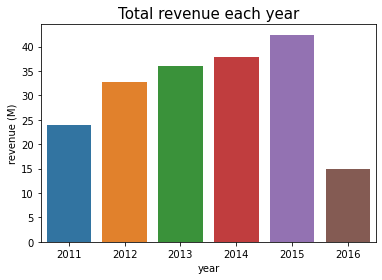

In [24]:
_ = sns.barplot(x = yearly_rev.index, y = yearly_rev)
_ = plt.ylabel('revenue (M)')
_ = plt.title('Total revenue each year', fontsize = 15)

In [25]:
df.groupby('year').date.nunique().sort_index()

year
2011    337
2012    366
2013    365
2014    365
2015    365
2016    115
Name: date, dtype: int64

Note: Our data do not cover full year for 2011 and 2016, But look like the business grow up every year. In order to confirm that the business also grow in 2016, one should instead normalize the revenue by the number of day each year.

In [26]:
day_each_year = df.groupby('year').date.nunique().sort_index()
day_each_year

year
2011    337
2012    366
2013    365
2014    365
2015    365
2016    115
Name: date, dtype: int64

In [27]:
avg_yearly_rev = yearly_rev / day_each_year

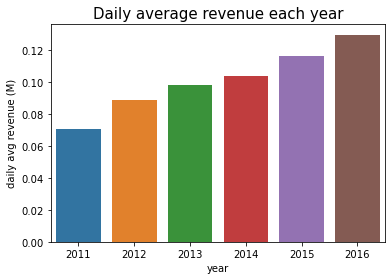

In [28]:
_ = sns.barplot(x = avg_yearly_rev.index, y = avg_yearly_rev)
_ = plt.ylabel('daily avg revenue (M)')
_ = plt.title('Daily average revenue each year', fontsize = 15)

So, we really get an upward trend.

### number of prouct

In [29]:
yearly_prod = df.groupby('year').num_prod_sale.sum()

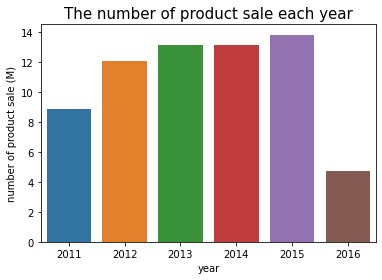

In [30]:
_ = sns.barplot(x = yearly_prod.index, y = yearly_prod)
_ = plt.ylabel('number of product sale (M)')
_ = plt.title('The number of product sale each year', fontsize = 15)

Note: number of product also increase every year.

## Monthly sale

### revenue

In [31]:
year_month_rev = df.groupby(['year', 'month']).revenue.sum().reset_index()

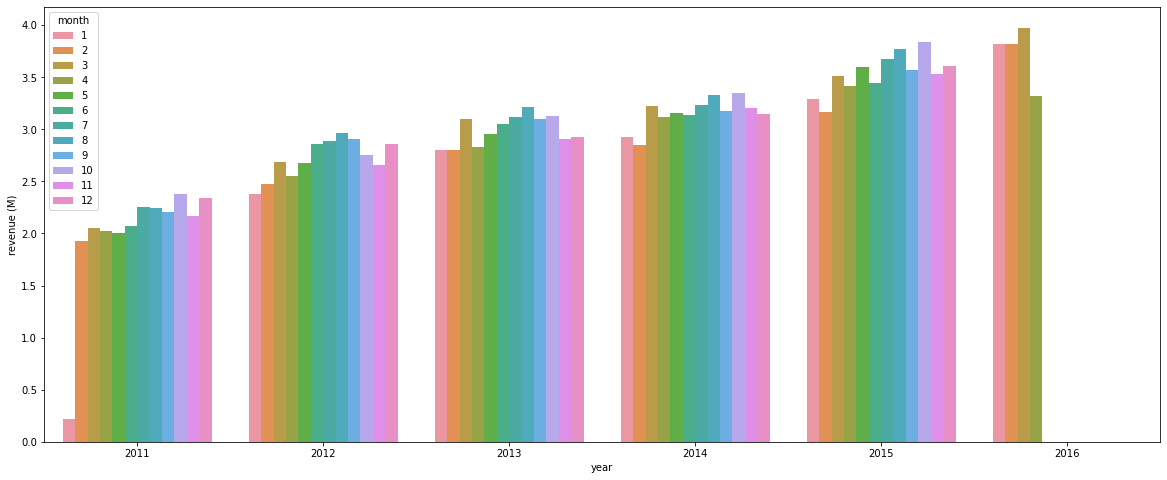

In [32]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = year_month_rev, x = 'year', y = 'revenue', hue = 'month')
_ = plt.ylabel('revenue (M)')

Visually, there is no apparent special month, the trend just go up as the time pass.

### number of product

In [33]:
year_month_prod = df.groupby(['year', 'month']).num_prod_sale.sum().reset_index()

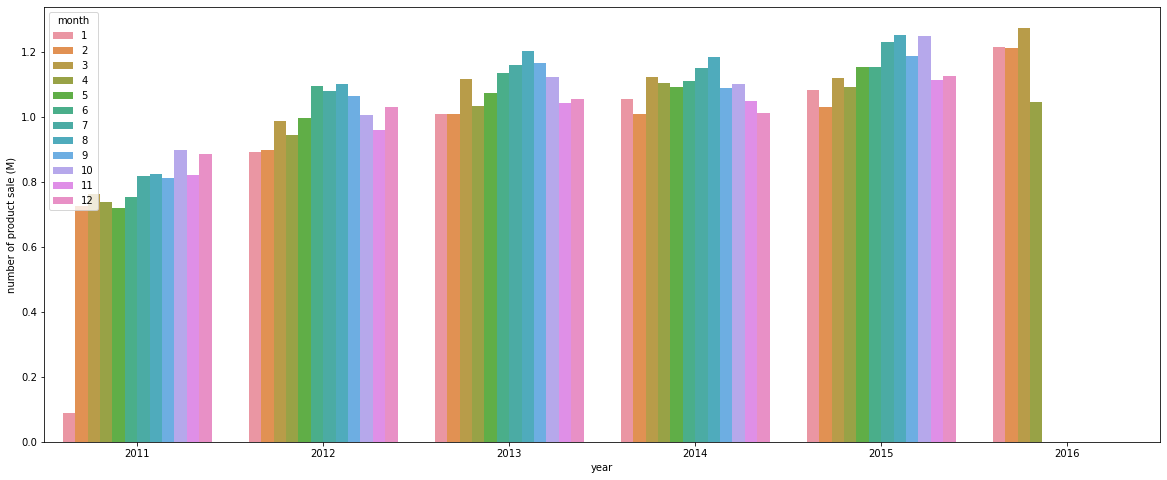

In [34]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = year_month_prod, x = 'year', y = 'num_prod_sale', hue = 'month')
_ = plt.ylabel('number of product sale (M)')

## State sale

### revenue

In [35]:
yearly_state_rev = df.groupby(['state_id', 'year']).revenue.sum().reset_index()

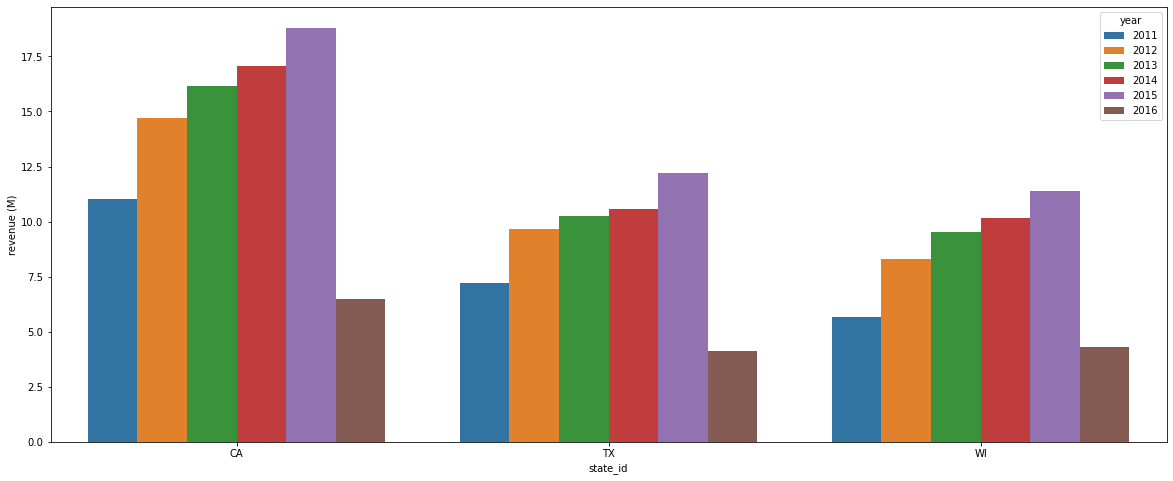

In [36]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = yearly_state_rev, x = 'state_id', y = 'revenue', hue = 'year')
_ = plt.ylabel('revenue (M)')

Note: Revenue increase in every state every year

### number of product

In [37]:
yearly_state_prod = df.groupby(['state_id', 'year']).num_prod_sale.sum().reset_index()

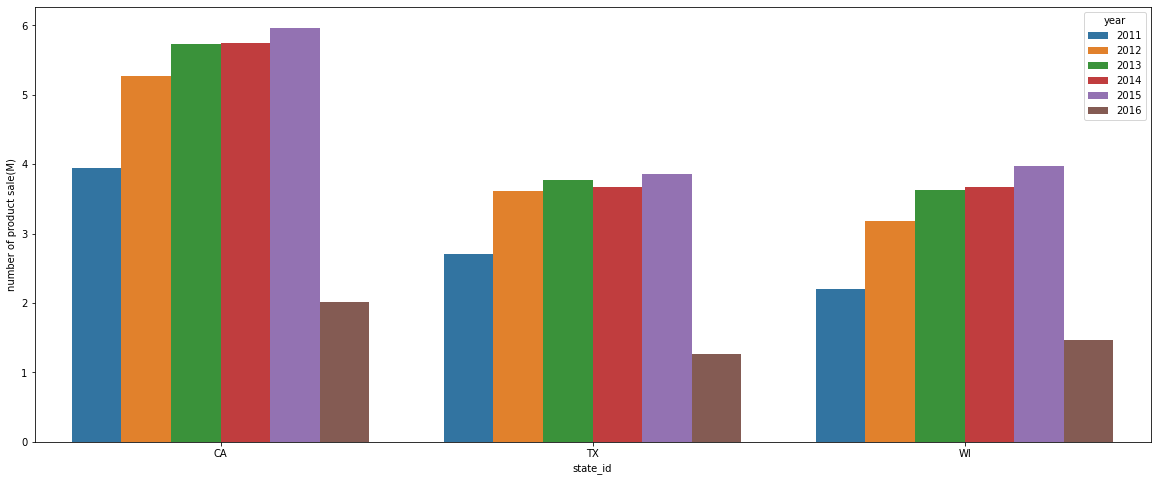

In [38]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = yearly_state_prod, x = 'state_id', y = 'num_prod_sale', hue = 'year')
_ = plt.ylabel('number of product sale(M)')

## Store sale

### revenue

In [39]:
yearly_store_rev = df.groupby(['store_id', 'year']).revenue.sum().reset_index()

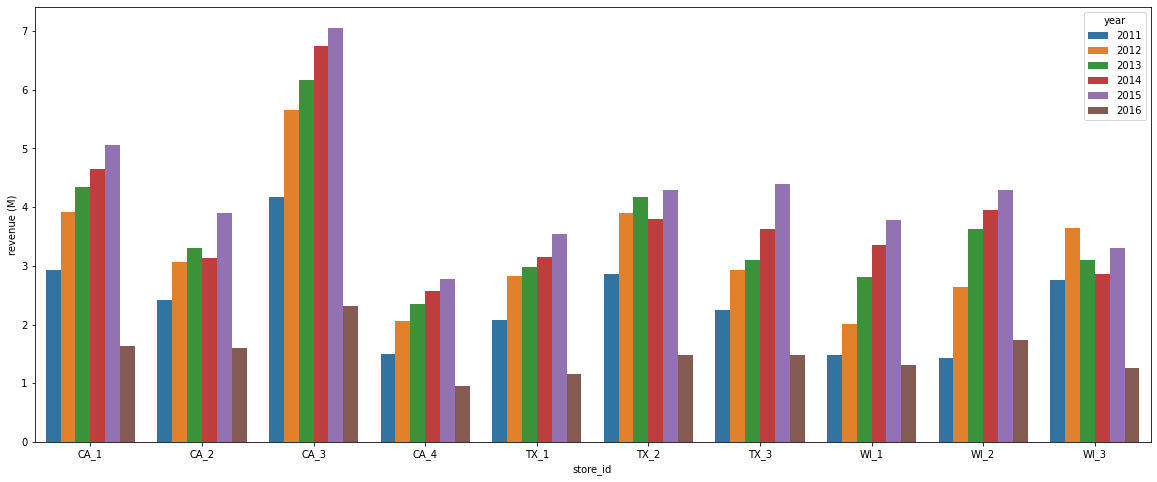

In [40]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = yearly_store_rev, x = 'store_id', y = 'revenue', hue = 'year')
_ = plt.ylabel('revenue (M)')

Note: Not all store show increasing trend, e.g. WI_3. CA_3 obtains the highest revenue by far every year.

### number of product

In [41]:
yearly_store_prod = df.groupby(['store_id', 'year']).num_prod_sale.sum().reset_index()

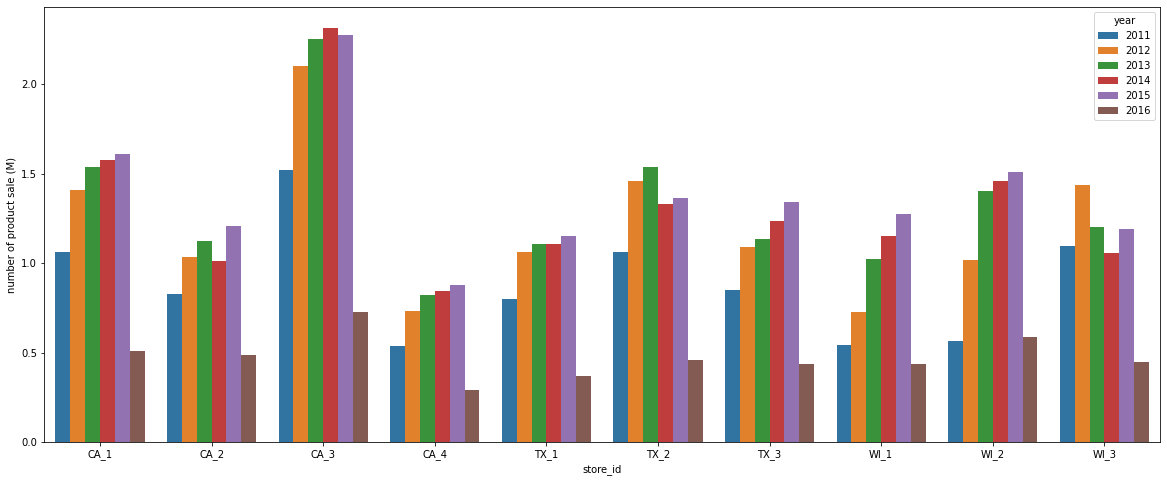

In [42]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = yearly_store_prod, x = 'store_id', y = 'num_prod_sale', hue = 'year')
_ = plt.ylabel('number of product sale (M)')

Note: CA_3 also has the highest number of prod sale by far every year.

## Product popularity

### top 5 popularity

In [43]:
yearly_prod_pop = df.groupby(['year', 'item_id']).sale.sum().reset_index()

In [44]:
top5_yearly_prod_pop = yearly_prod_pop.sort_values(by = ['year', 'sale'], ascending = [True,False]).groupby('year').head(5)

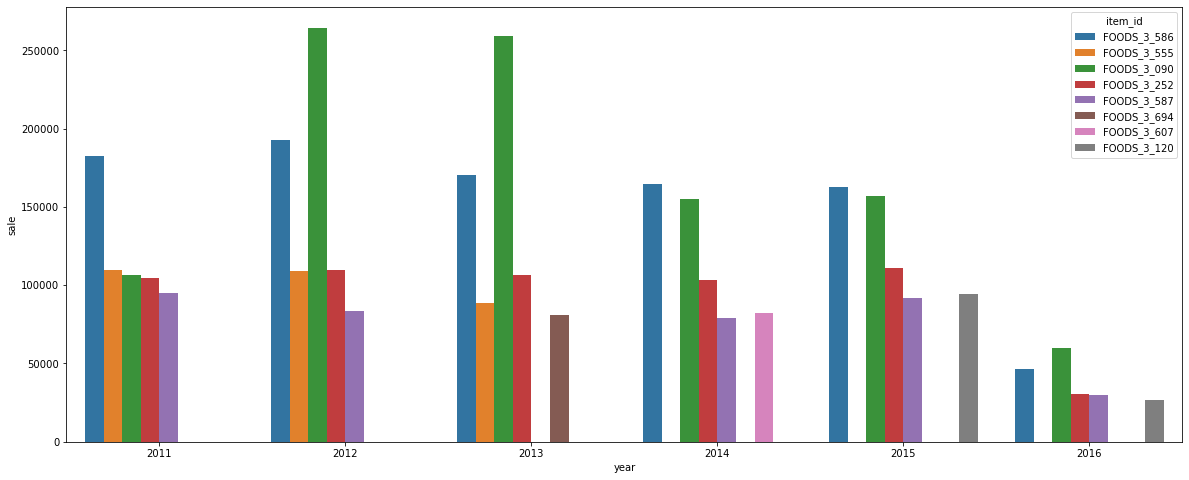

In [45]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = top5_yearly_prod_pop, x = 'year', y = 'sale', hue = 'item_id')

Note: Food is the most popular item category, top 5 product sale every is in food category. Moreover, some specific food, namely FOODS_3_586, FOODS_3_090, FOODS_3_252, are in the top 5 most popular product every year.

### top 5 food

In [46]:
yearly_food_pop = df[df.cat_id == 'FOODS']
yearly_food_pop = yearly_food_pop.groupby(['year', 'item_id']).sale.sum().reset_index()
top5_yearly_food_pop = yearly_food_pop.sort_values(by = ['year', 'sale'], ascending = [True,False]).groupby('year').head(5)

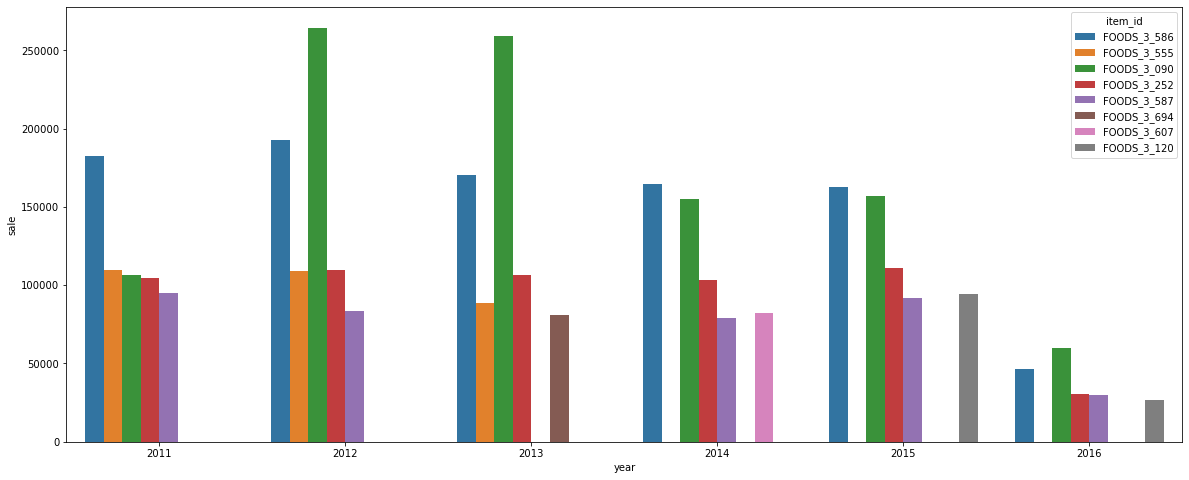

In [47]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = top5_yearly_food_pop, x = 'year', y = 'sale', hue = 'item_id')

### top 5 hobbies

In [48]:
yearly_hob_pop = df[df.cat_id == 'HOBBIES']
yearly_hob_pop = yearly_hob_pop.groupby(['year', 'item_id']).sale.sum().reset_index()
top5_yearly_hob_pop = yearly_hob_pop.sort_values(by = ['year', 'sale'], ascending = [True,False]).groupby('year').head(5)

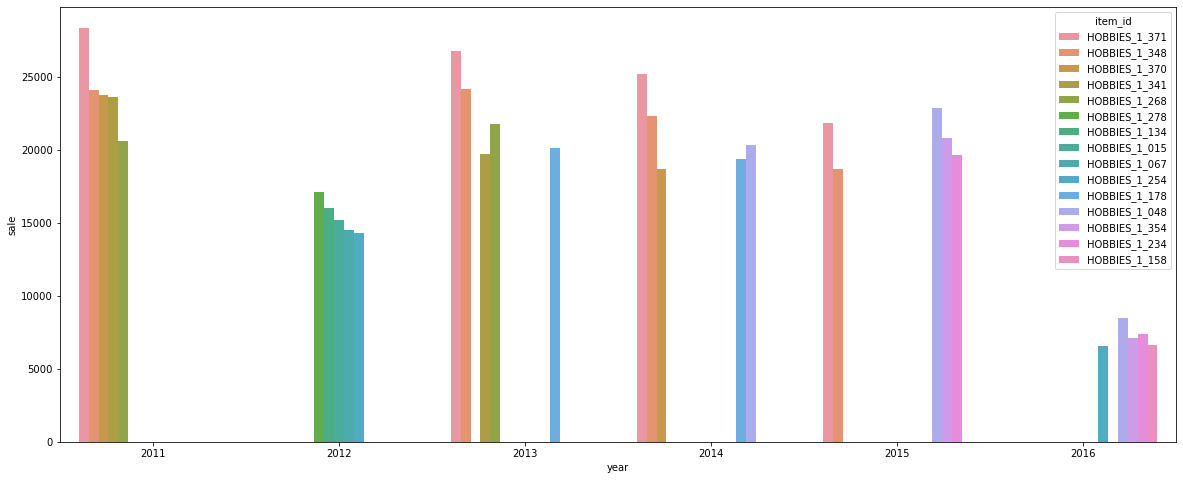

In [49]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = top5_yearly_hob_pop, x = 'year', y = 'sale', hue = 'item_id')

### top 5 household

In [50]:
yearly_house_pop = df[df.cat_id == 'HOUSEHOLD']
yearly_house_pop = yearly_house_pop.groupby(['year', 'item_id']).sale.sum().reset_index()
top5_yearly_house_pop = yearly_house_pop.sort_values(by = ['year', 'sale'], ascending = [True,False]).groupby('year').head(5)

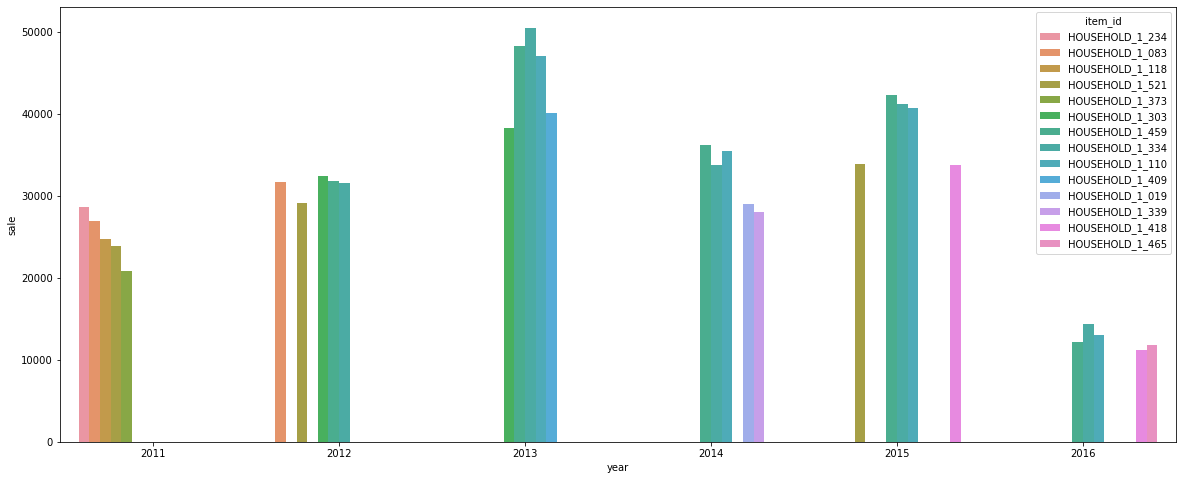

In [51]:
_ = plt.figure(figsize=(20,8))
_ = sns.barplot(data = top5_yearly_house_pop, x = 'year', y = 'sale', hue = 'item_id')

Note: Interestingly, the trend for hobbie and household change every year, but the popular food remain the same.

# Model

In [52]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,num_prod_sale
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0.0


In [53]:
df['date'] = pd.to_datetime(df['date'])
ids = sales_train_val['id'].tolist()
d_cols = [x for x in sales_train_val.columns if 'd_' in x]

The object is to predict 28 days future sale of all products for all stores. But first let try with just one product in one store. We will use facebook prophet for the forecasting.

In [54]:
x1 = df[df['id'] == ids[1]][['date', 'sale']].reset_index(drop = True)
x1.rename(columns = {'date':'ds', 'sale': 'y'}, inplace = True)

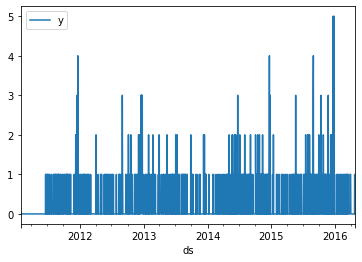

In [55]:
_ = x1.set_index('ds').plot()

In [56]:
model = Prophet(daily_seasonality=True)
model.fit(x1)

In [57]:
# cross varidation
df_cv = cross_validation(model, initial='1460 days', period='100 days', horizon = '100 days')

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [58]:
# evaluate
print('mean square error', mean_squared_error(df_cv.y, df_cv.yhat))
print('mean absolute error', mean_absolute_error(df_cv.y, df_cv.yhat))

mean square error 0.4323021714390282
mean absolute error 0.4589005562634776


In [59]:
# forecast
future = model.make_future_dataframe(periods=28)
forecast = model.predict(future)

For more product and store, one can loop over the step above.

In [60]:
model_all = {}
mse_all_model = {}
mae_all_model = {}
forcast_all_model = {}

for i in range(5): # in practice, change range(5) to range(len(ids)), here is just an example for small data.

    # select product_store date
    x1 = df[df['id'] == ids[i]][['date', 'sale']].reset_index(drop = True)
    x1.rename(columns = {'date':'ds', 'sale': 'y'}, inplace = True)

    # fit
    model = Prophet(daily_seasonality=True)
    model.fit(x1)
    model_all[ids[i]] = model

    # cross varidation
    df_cv = cross_validation(model, initial='1460 days', period='100 days', horizon = '100 days')

    # evaluate
    mse = mean_squared_error(df_cv.y, df_cv.yhat)
    mae = mean_absolute_error(df_cv.y, df_cv.yhat)
    mse_all_model[ids[i]] = mse
    mae_all_model[ids[i]] = mae

    # forecast
    future = model.make_future_dataframe(periods=28)
    forecast = model.predict(future)
    forcast_all_model[ids[i]] = forecast

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:Making 4 forecasts with cutoffs between 2015-03-21 00:00:00 and 2016-01-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [69]:
#evaluation
mse_list = list(mse_all_model.values())

avg_mse = sum(mse_list)/len(mse_list)

In [70]:
avg_mse

1.5659809656184809